In [1]:

import os
import sys
import importlib
import copy
from collections import defaultdict
sys.path.insert(0, '/n/groups/htem/Segmentation/shared-nondev/cb2_segmentation/analysis_mf_grc')

from tools_pattern import get_eucledean_dist

# script_n = os.path.basename(__file__).split('.')[0]
script_n = 'distribution_123share_210512_all'

import my_plot
importlib.reload(my_plot)
from my_plot import MyPlotData, my_box_plot

def to_ng_coord(coord):
    return (
        int(coord[0]/4),
        int(coord[1]/4),
        int(coord[2]/40),
        )

import compress_pickle

# input_graph = compress_pickle.load('/n/groups/htem/Segmentation/shared-nondev/cb2_segmentation/analysis_mf_grc/'\
#                                    'mf_grc_model/input_graph_201114_restricted_z.gz')
fname = ('/n/groups/htem/Segmentation/shared-nondev/cb2_segmentation/analysis_mf_grc/'\
#                                    'mf_grc_model/input_graph_210407_xlim_90_140_zlim_0.0_44.0.gz')
                                   'mf_grc_model/input_graph_210407_all.gz')
input_graph = compress_pickle.load(fname)

# z_min = 19800
# z_max = 29800
z_min = 19800-2500
z_max = 29800+2500
# GrCs are fully reconstructed and proofread from 90k to 150k
# MFs are from 70k to 160k
x_min = 95*1000*4
x_max = 145*1000*4
# radius = 200

n_randoms = 5
replication_hist2 = defaultdict(int)
grc_ids = set()
mf_ids = set()
replicated_2shares = defaultdict(int)

def get_prob(in_graph, unique_count=False, count_within_box=True, return_counted=False):
    n_common_pairs = 0
    processed = set()
    total_n_pairs = 0
    hist = defaultdict(int)
    n = 0
    counted_grcs = 0
    for grc_i_id in in_graph.grcs:
        n += 1
        grc_i = in_graph.grcs[grc_i_id]
        x, y, z = grc_i.soma_loc
        if count_within_box:
            if x < x_min or x > x_max:
                continue
            if z < z_min or z > z_max:
                continue
        counted_grcs += 1
        grc_ids.add(grc_i_id)
        rosettes_i = set([mf[0] for mf in grc_i.edges])
        for r in rosettes_i:
            mf_ids.add(r)
        for grc_j_id in in_graph.grcs:
            if grc_i_id == grc_j_id:
                continue
            if unique_count and (grc_i_id, grc_j_id) in processed:
                continue
            processed.add((grc_i_id, grc_j_id))
            processed.add((grc_j_id, grc_i_id))
            grc_j = in_graph.grcs[grc_j_id]
            x, y, z = grc_j.soma_loc
#             if count_within_box:
#                 if x < x_min or x > x_max:
#                     continue
#                 if z < z_min or z > z_max:
#                     continue
            common_rosettes = set([mf[0] for mf in grc_j.edges])
            common_rosettes = common_rosettes & rosettes_i
            hist[len(common_rosettes)] += 1
            if len(common_rosettes) == 2:
                replication_hist2[grc_i_id] += 1
                common_rosettes = tuple(sorted(list(common_rosettes)))
                replicated_2shares[common_rosettes] += 1
    for k in hist:
        # fix 0 datapoint plots
        if hist[k] == 0:
            hist[k] = 1
    if return_counted:
        return hist, counted_grcs
    else:
        return hist

input_observed = copy.deepcopy(input_graph)
hist_data, n_grcs = get_prob(input_observed, count_within_box=False, return_counted=True)

print(n_grcs)
print(hist_data)
# n_grcs = len(input_graph.grcs)

2499
defaultdict(<class 'int'>, {0: 6061972, 1: 173518, 2: 6822, 3: 186, 4: 4})


In [2]:
print(len(mf_ids))

564


In [3]:
replication_hist2_list = []
for grc in grc_ids:
    if grc in replication_hist2:
        replication_hist2_list.append((grc, replication_hist2[grc]))
    else:
        replication_hist2_list.append((grc, 0))

replication_hist2_list_sorted = sorted(replication_hist2_list, key=lambda x: x[1])

In [4]:
mpd = MyPlotData()
mpd_count = MyPlotData()
i = 0
for grc_id, count in replication_hist2_list_sorted:
    mpd_count.add_data_point(
        count=count,
        grc_id=grc_id,
        i=i,
        model='Observed',
    )
    i += 1

Height: 4, Aspect: 2


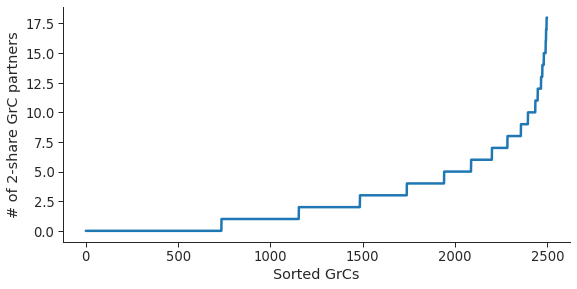

In [5]:

importlib.reload(my_plot); my_plot.my_relplot(
    mpd_count,
    x='i',
    y='count',
#     kind='hist',
    context='paper',
    linewidth=2.5,
#     kde=True,
#     stat='density',
    height=4,
    aspect=2,
    y_axis_label='# of 2-share GrC partners',
    x_axis_label='Sorted GrCs',
    save_filename=f'{script_n}_line.svg',
    show=True,
    )

In [7]:
replicated_2shares_list = [(k, v) for k, v in replicated_2shares.items()]
replicated_2shares_list.sort(key=lambda x: x[1])
mf_2share_representation = defaultdict(int)
for mfs, count in replicated_2shares_list:
#     print(i)
    for mf in mfs:
        mf_2share_representation[mf] += count

In [9]:
# mf_2share_representation
compress_pickle.dump(mf_2share_representation, 'distribution_123share_210512_all_mfs_rep.gz')

In [2]:

import tools_mf_graph
importlib.reload(tools_mf_graph)
from tools_mf_graph import GCLGraph
fname = ('/n/groups/htem/Segmentation/shared-nondev/cb2_segmentation/analysis_mf_grc/'\
                                   'mf_grc_model/input_graph_210407_xlim_90_140_zlim_0.0_44.0.gz')
input_graph = compress_pickle.load(fname)
input_graph.avg_edge_count_by_depth = None

n_randoms = 5
hist_random_21 = []

for n in range(n_randoms):
    # input_graph.randomize_graph(random_model=True)
    input_graph.randomize_graph_by_grc2(
        single_connection_per_pair=True,
        constant_grc_degree='depth',
        constant_dendrite_length=21000,
#         always_pick_closest_rosette=True,
        )
    hist_random = get_prob(input_graph)
    hist_random_21.append(hist_random)


Average num_claw_per_grc: 3.3192161820480406
Average num_claw_per_grc: 3.3192161820480406
Average num_claw_per_grc: 3.3192161820480406
Average num_claw_per_grc: 3.3192161820480406
Average num_claw_per_grc: 3.3192161820480406


In [3]:

n_randoms = 5
hist_random_17 = []

for n in range(n_randoms):
    # input_graph.randomize_graph(random_model=True)
    input_graph.randomize_graph_by_grc2(
        single_connection_per_pair=True,
        constant_grc_degree='depth',
        constant_dendrite_length=21000,
#         always_pick_closest_rosette=True,
        )
    hist_random = get_prob(input_graph)
    hist_random_17.append(hist_random)


Average num_claw_per_grc: 3.3192161820480406
Average num_claw_per_grc: 3.3192161820480406
Average num_claw_per_grc: 3.3192161820480406
Average num_claw_per_grc: 3.3192161820480406
Average num_claw_per_grc: 3.3192161820480406


In [4]:

import tools_mf_graph
importlib.reload(tools_mf_graph)
from tools_mf_graph import GCLGraph
fname = ('/n/groups/htem/Segmentation/shared-nondev/cb2_segmentation/analysis_mf_grc/'\
                                   'mf_grc_model/input_graph_210407_xlim_90_140_zlim_0.0_44.0.gz')
input_graph = compress_pickle.load(fname)
input_graph.avg_edge_count_by_depth = None
input_graph.avg_dendrite_len = None

n_randoms = 5
hist_random_avg = []

for n in range(n_randoms):
    # input_graph.randomize_graph(random_model=True)
    input_graph.randomize_graph_by_grc2(
        single_connection_per_pair=True,
        constant_grc_degree='depth',
        constant_dendrite_length=True,
#         always_pick_closest_rosette=True,
        )
    hist = get_prob(input_graph)
    hist_random_avg.append(hist)


Average num_claw_per_grc: 3.3192161820480406
Average dendrite len: 21843
21843
Average num_claw_per_grc: 3.3192161820480406
21843
Average num_claw_per_grc: 3.3192161820480406
21843
Average num_claw_per_grc: 3.3192161820480406
21843
Average num_claw_per_grc: 3.3192161820480406
21843


In [5]:

n_randoms = 5
hist_shuffle = []

for n in range(n_randoms):
    input_graph.randomize_graph_by_grc(
        mf_dist_margin=4000,
        single_connection_per_pair=True,
        )
    hist = get_prob(input_graph)
    hist_shuffle.append(hist)


In [6]:


global_random_n_grcs, hist_global_random = compress_pickle.load('/n/groups/htem/Segmentation/shared-nondev/cb2_segmentation/analysis_mf_grc/mf_grc_analysis/share_distribution/gen_global_random_7k_204k_data_2000.gz')

import compress_pickle
compress_pickle.dump((
    hist_data,
    hist_random,
    global_random_n_grcs,
    hist_global_random,
    ), f"{script_n}_data.gz")
# normalize

# total_n_pairs = hist_data[0] + hist_data[1] + hist_data[2] + hist_data[3]
# global_random_n_grcs = 204000


Height: 2.142857142857143, Aspect: 1.4


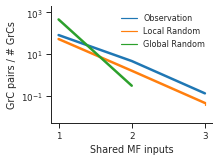

In [7]:

mpd_data = MyPlotData()
for n_share in [1, 2, 3]:
    if n_share in hist_data:
        mpd_data.add_data_point(
            n_share=n_share,
            count=hist_data[n_share]/n_grcs,
            type='Observation',
            )
    for hist_random in hist_random_avg:
        if n_share in hist_random:
            mpd_data.add_data_point(
                n_share=n_share,
                count=hist_random[n_share]/n_grcs,
                type='Local Random',
                )
    if n_share in hist_global_random:
        mpd_data.add_data_point(
            n_share=n_share,
            # need to divide by 2 because we're sampling only 2/200 grcs
            # (or multiply others by 2)
#             count=hist_global_random[n_share]/global_random_n_grcs/2,
            count=hist_global_random[n_share]/global_random_n_grcs,
            type='Global Random',
            )

def custom_legend_fn(plt):
#     plt.legend(bbox_to_anchor=(1.025, .8), loc='upper left', borderaxespad=0.)
    plt.legend(loc='upper right', frameon=False, markerscale=2, prop={'size': 8})


# importlib.reload(my_plot); my_plot.my_relplot(
#     mpd_data,
#     x='n_share',
#     y='count',
#     hue='type',
#     # hue_order=['Data', 'Random Model'],
#     kind='scatter',
#     context='paper',
#     # ylim=[.005, 50],
#     ylim=[.005, 2000],
#     xlim=[.7, 3.3],
#     log_scale_y=True,
#     s=150,
#     # xticklabels=['', 1, '', 2, '', 3, ''],
#     xticks=[1, 2, 3],
#     height=4,
#     aspect=1.1,
#     custom_legend_fn=custom_legend_fn,
#     y_axis_label='GrC pairs / # GrCs',
#     x_axis_label='Shared Inputs',
#     # save_filename=f'{script_n}.pdf',
#     save_filename=f'{script_n}.svg',
#     show=True,
#     )


importlib.reload(my_plot); my_plot.my_relplot(
    mpd_data,
    x='n_share',
    y='count',
    hue='type',
    # hue_order=['Data', 'Random Model'],
    kind='line',
    err_style="bars",
    ci=68,
    markers=True,
    dashes=False,
#     s=150,
    context='paper',
    # ylim=[.005, 50],
    ylim=[.005, 2000],
    xlim=[.9, 3.1],
    log_scale_y=True,
    linewidth=2.5,
#     s=150,
    # xticklabels=['', 1, '', 2, '', 3, ''],
    xticks=[1, 2, 3],
#     height=4,
    width=3,
    aspect=1.4,
    font_scale=1,
    custom_legend_fn=custom_legend_fn,
    y_axis_label='GrC pairs / # GrCs',
    x_axis_label='Shared MF inputs',
    # save_filename=f'{script_n}.pdf',
    save_filename=f'{script_n}_line.svg',
    show=True,
    )


Height: 2.142857142857143, Aspect: 1.4


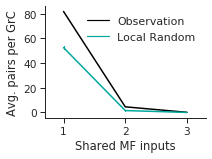

In [31]:
n_grcs=142

mpd_data = MyPlotData()
for n_share in [1, 2, 3]:
    if n_share in hist_data:
        mpd_data.add_data_point(
            n_share=n_share,
            count=hist_data[n_share]/n_grcs,
            type='Observation',
            )
#     for hist_random in hist_random_17:
#         if n_share in hist_random:
#             mpd_data.add_data_point(
#                 n_share=n_share,
#                 count=hist_random[n_share]/n_grcs,
#                 type='Local Random',
#                 )
    for hist_random in hist_random_avg:
        if n_share in hist_random:
            mpd_data.add_data_point(
                n_share=n_share,
                count=hist_random[n_share]/n_grcs,
                type='Local Random',
                )
#     for hist_random in hist_shuffle:
#         if n_share in hist_random:
#             mpd_data.add_data_point(
#                 n_share=n_share,
#                 count=hist_random[n_share]/n_grcs,
#                 type='Shuffle',
#                 )

palette = {
    'Observation': 'black',
    'Local Random': '#00a79d',
}

def custom_legend_fn(plt):
#     plt.legend(bbox_to_anchor=(1.025, .8), loc='upper left', borderaxespad=0.)
    plt.legend(loc='upper right', frameon=False, markerscale=2, prop={'size': 11})

importlib.reload(my_plot); my_plot.my_relplot(
    mpd_data,
    x='n_share',
    y='count',
    hue='type',
    # hue_order=['Data', 'Random Model'],
    kind='line',
    err_style="bars",
#     ci=68,
    markers=True,
    dashes=False,
#     s=150,
    context='paper',
    # ylim=[.005, 50],
#     ylim=[None, 100],
#     ylim=[None, 20],
    xlim=[.7, 3.3],
    linewidth=1.5,
    palette=palette,
#     log_scale_y=True,
#     s=150,
    # xticklabels=['', 1, '', 2, '', 3, ''],
    xticks=[1, 2, 3],
#     width=3.1,
#     height=3,
    width=3,
    aspect=1.4,
    font_scale=1.2,
#     aspect=1.1,
    custom_legend_fn=custom_legend_fn,
#     y_axis_label='GrC pairs / # GrCs',
    y_axis_label='Avg. pairs per GrC',
    x_axis_label='Shared MF inputs',
    # save_filename=f'{script_n}.pdf',
    save_filename=f'{script_n}_line_linear.svg',
    show=True,
    )


Height: 2.142857142857143, Aspect: 1.4


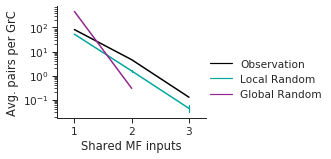

In [30]:
n_grcs=142

mpd_data = MyPlotData()
for n_share in [1, 2, 3]:
    if n_share in hist_data:
        mpd_data.add_data_point(
            n_share=n_share,
            count=hist_data[n_share]/n_grcs,
            type='Observation',
            )
#     for hist_random in hist_random_17:
#         if n_share in hist_random:
#             mpd_data.add_data_point(
#                 n_share=n_share,
#                 count=hist_random[n_share]/n_grcs,
#                 type='Local Random',
#                 )
    for hist_random in hist_random_avg:
        if n_share in hist_random:
            mpd_data.add_data_point(
                n_share=n_share,
                count=hist_random[n_share]/n_grcs,
                type='Local Random',
                )
#     for hist_random in hist_shuffle:
#         if n_share in hist_random:
#             mpd_data.add_data_point(
#                 n_share=n_share,
#                 count=hist_random[n_share]/n_grcs,
#                 type='Shuffle',
#                 )
    if n_share in hist_global_random:
        mpd_data.add_data_point(
            n_share=n_share,
            # need to divide by 2 because we're sampling only 2/200 grcs
            # (or multiply others by 2)
#             count=hist_global_random[n_share]/global_random_n_grcs/2,
            count=hist_global_random[n_share]/global_random_n_grcs,
            type='Global Random',
            )

palette = {
    'Observation': 'black',
    'Local Random': '#00a79d',
    'Global Random': '#92278f',
}

def custom_legend_fn(plt):
#     plt.legend(bbox_to_anchor=(1.025, .8), loc='upper left', borderaxespad=0.)
    plt.legend(loc='upper right', frameon=False, markerscale=2, prop={'size': 11})

importlib.reload(my_plot); my_plot.my_relplot(
    mpd_data,
    x='n_share',
    y='count',
    hue='type',
    # hue_order=['Data', 'Random Model'],
    kind='line',
    err_style="bars",
#     ci=68,
    markers=True,
    dashes=False,
#     s=150,
    context='paper',
    # ylim=[.005, 50],
#     ylim=[None, 100],
#     ylim=[None, 20],
    xlim=[.7, 3.3],
    linewidth=1.5,
    palette=palette,
    log_scale_y=True,
#     s=150,
    # xticklabels=['', 1, '', 2, '', 3, ''],
    xticks=[1, 2, 3],
#     width=3.1,
#     height=3,
    width=3,
    aspect=1.4,
    font_scale=1.2,
#     aspect=1.1,
#     custom_legend_fn=custom_legend_fn,
#     y_axis_label='GrC pairs / # GrCs',
    y_axis_label='Avg. pairs per GrC',
    x_axis_label='Shared MF inputs',
    # save_filename=f'{script_n}.pdf',
    save_filename=f'{script_n}_line_log.svg',
    show=True,
    )


In [9]:
n_grcs=142
print(hist_data)
print(hist_random_17[0])
print(hist_data[2]/n_grcs)
print(hist_random_17[2][2]/n_grcs)
print(hist_random_avg[2][2]/n_grcs)
print(hist_shuffle[2][2]/n_grcs)
print()
print(hist_data[1]/n_grcs)
print(hist_random_17[2][1]/n_grcs)
print(hist_random_avg[2][1]/n_grcs)
print(hist_shuffle[2][1]/n_grcs)

defaultdict(<class 'int'>, {0: 212209, 1: 11624, 2: 651, 3: 18})
defaultdict(<class 'int'>, {0: 217047, 1: 7272, 2: 179, 3: 4})
4.584507042253521
1.3591549295774648
1.704225352112676
2.5492957746478875

81.85915492957747
50.41549295774648
54.04225352112676
68.80985915492958
